In [76]:
import pandas as pd
import numpy as np
# import the libraries
import datetime


import seaborn as sns # import seaborn for visualization of data
%matplotlib inline
import matplotlib.pyplot as plt#
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)


In [77]:
# Import the data from a txt file with lines of header and a specified datetime column

df = pd.read_csv("raw.txt", skiprows =18 ,delimiter=",",parse_dates=True,index_col='    DATE')

df.head()

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0


In [78]:
df.columns

Index([' SOUID', '   TG', ' Q_TG'], dtype='object')

In [79]:
# Rename columns to make it easy to handle
df.rename(columns = {' SOUID':'souid','    DATE':'date', '   TG':'temp', ' Q_TG':'Q_TG'}, inplace = True)

# Clean Data

In [80]:

df['real_temp'] = 0.1 * df['temp']
df.head()

,souid,temp,Q_TG,real_temp
DATE,,,,
1876-01-01,127488,22,0,2.2
1876-01-02,127488,25,0,2.5
1876-01-03,127488,3,0,0.3
1876-01-04,127488,-58,0,-5.8
1876-01-05,127488,-98,0,-9.8


In [81]:
df.info()
data = df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53416 entries, 1876-01-01 to 2022-03-31
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   souid      53416 non-null  int64  
 1   temp       53416 non-null  int64  
 2   Q_TG       53416 non-null  int64  
 3   real_temp  53416 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.0 MB


In [82]:
# Create columns from datetime
data['day'] = data.index.day
data['month'] = data.index.month
data['year'] = data.index.year

In [83]:
data.head()

,souid,temp,Q_TG,real_temp,day,month,year
DATE,,,,,,,
1876-01-01,127488,22,0,2.2,1,1,1876
1876-01-02,127488,25,0,2.5,2,1,1876
1876-01-03,127488,3,0,0.3,3,1,1876
1876-01-04,127488,-58,0,-5.8,4,1,1876
1876-01-05,127488,-98,0,-9.8,5,1,1876


In [84]:
pd.isnull(data).sum()

souid        0
temp         0
Q_TG         0
real_temp    0
day          0
month        0
year         0
dtype: int64

In [85]:
# Fix the missing values in temperature.
# Start with creating a new column that contains the values of Real_temp withe row_shifting of one year in time
data['shifted'] = data['real_temp'].shift(-365)
#As a result we have in the shifted column the values of the previous year and we substitute this part of the year with the shifted values
# In other words its a data pach with data from 1944 year
data.loc[data['real_temp']< -50, 'real_temp'] = data.loc[data['Q_TG']== 9, 'shifted']
# Drop data columns not needed
data.drop(columns=['souid', 'temp','shifted'],inplace = True)

In [86]:
pd.isnull(data).sum()

Q_TG         0
real_temp    1
day          0
month        0
year         0
dtype: int64

In [87]:
# Check which value is still missing and replace it manually with the value of the previous year
df[df['real_temp'].isna()]
data.loc['2022-03-31 00:00:00','real_temp'] = 7.7

In [88]:
pd.isnull(data).sum()

Q_TG         0
real_temp    0
day          0
month        0
year         0
dtype: int64

In [89]:
# Replace outliers with NaN values if needed
#df['temp'].replace(-9999, pd.NA , inplace=True)

In [90]:
# Attempt to fill in the outliers with data from the previous year with other way. 
# Not succesfull
#data.loc['1945-04-25 00:00:00':'1945-11-05 00:00:00','real_temp'] = data.loc['1944-04-25 00:00:00':'1944-11-05 00:00:00','real_temp']
#data.loc['2022-03-31 00:00:00':'2022-03-30 00:00:00']['real_temp'] = data.loc['2021-03-31 00:00:00':'2021-03-30 00:00:00']['real_temp']

# Have a look of the data

<AxesSubplot:xlabel='year', ylabel='real_temp'>

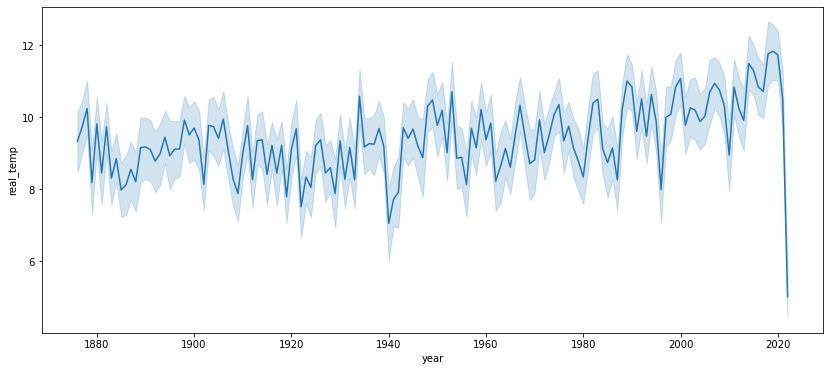

In [91]:
sns.lineplot(x = data['year'], y =data['real_temp'])
#plt.xlim(1000, 3000)

<AxesSubplot:>

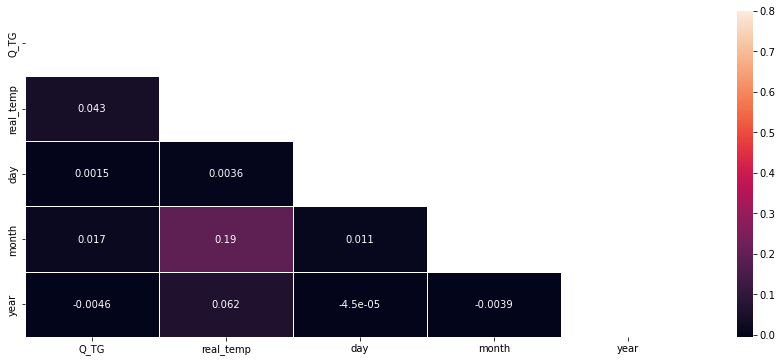

In [93]:
corrMatt = data.corr()
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=False, annot=True, ax=ax, linewidths=1)

In [94]:
# Create a timestep variable
data['timestep'] = list(range(len(data)))
data.head()


,Q_TG,real_temp,day,month,year,timestep
DATE,,,,,,
1876-01-01,0,2.2,1,1,1876,0
1876-01-02,0,2.5,2,1,1876,1
1876-01-03,0,0.3,3,1,1876,2
1876-01-04,0,-5.8,4,1,1876,3
1876-01-05,0,-9.8,5,1,1876,4


# First fit the trend! 

- try a linear

In [95]:
# Run a Linear Regression
m = LinearRegression()
data = data[(data['year'] <2021)]
X = data[['timestep']]
y = data['real_temp']
m.fit(X, y)

LinearRegression()

In [96]:
# Use the model to make a prediction
data['trend'] = m.predict(X)
data.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Q_TG,real_temp,day,month,year,timestep,trend
DATE,,,,,,,
1876-01-01,0,2.2,1,1,1876,0,8.527069
1876-01-02,0,2.5,2,1,1876,1,8.527103
1876-01-03,0,0.3,3,1,1876,2,8.527136
1876-01-04,0,-5.8,4,1,1876,3,8.527169
1876-01-05,0,-9.8,5,1,1876,4,8.527203


<AxesSubplot:xlabel='year', ylabel='trend'>

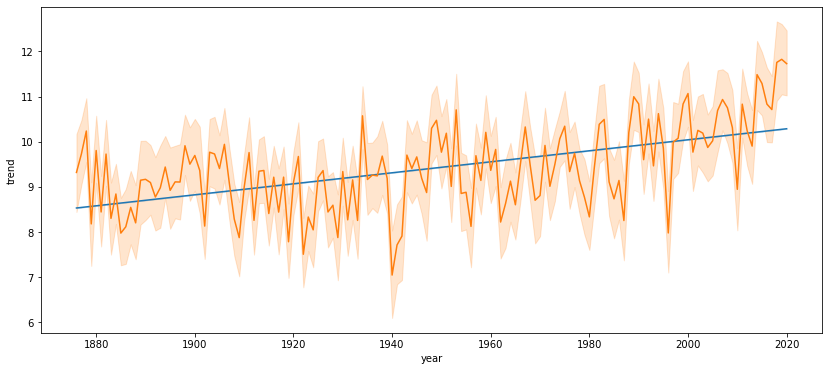

In [97]:
# plot data 
sns.lineplot(x = data['year'], y =data['trend'])
sns.lineplot(x = data['year'], y =data['real_temp'])

- try a polynomial low degree

In [98]:
# Fit the data with a polynomial to see the time evolution
def fit_with_poly(X, y, deg):
    poly = PolynomialFeatures(degree=deg,include_bias= True, interaction_only=False)
    X_poly = poly.fit_transform(X)
    lr = LinearRegression()
    lr.fit(X_poly,y)
    y_pred_poly = lr.predict(X_poly)
    return y_pred_poly, X_poly

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:xlabel='year', ylabel='trend'>

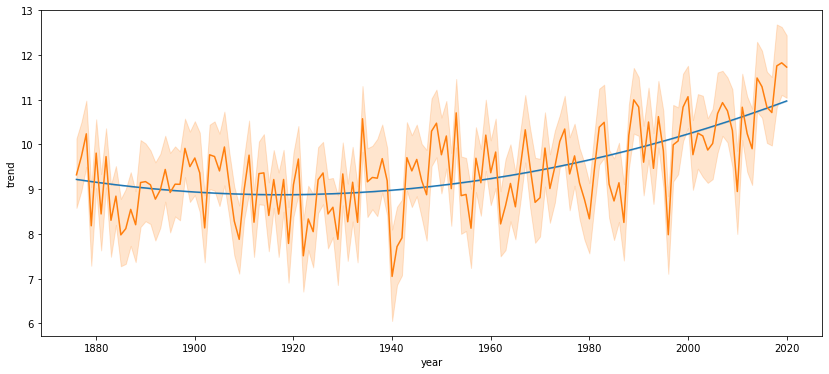

In [99]:
y_pred_poly, X_poly = fit_with_poly(X,y,2)
# Use the model to make a prediction
data['trend'] = y_pred_poly

sns.lineplot(x = data['year'], y =data['trend'])
sns.lineplot(x = data['year'], y =data['real_temp'])

# Step 5 - Model the seasonality

In [100]:
pd.get_dummies(data.index.month, prefix='month').set_index(data.index)

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,
1876-01-01,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0,0,0,0,0,0,0,0,0,0,0,1
2020-12-28,0,0,0,0,0,0,0,0,0,0,0,1
2020-12-29,0,0,0,0,0,0,0,0,0,0,0,1


In [101]:
# One-Hot-Encoding the month
seasonal_dummies = pd.get_dummies(data.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(data.index)
# sklearn.preprocessing.OneHotEncoder

data = data.join(seasonal_dummies)

In [106]:
# Define X and y
X = data.drop(columns=['Q_TG','real_temp','day', 'year', 'month', 'trend'])
y = data['real_temp']

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,
1876-01-01,0,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,2,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,3,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,52956,0,0,0,0,0,0,0,0,0,0,1
2020-12-28,52957,0,0,0,0,0,0,0,0,0,0,1
2020-12-29,52958,0,0,0,0,0,0,0,0,0,0,1


In [108]:
y

    DATE
1876-01-01    2.2
1876-01-02    2.5
1876-01-03    0.3
1876-01-04   -5.8
1876-01-05   -9.8
             ... 
2020-12-27    1.6
2020-12-28    2.8
2020-12-29    2.3
2020-12-30    2.5
2020-12-31    2.6
Name: real_temp, Length: 52961, dtype: float64

In [110]:
lr =LinearRegression()
lr.fit(X, y)

LinearRegression()

In [111]:
# Create a model with trend and seasonality
data['trend_seasonal'] = lr.predict(X)
data.head()

,Q_TG,real_temp,day,month,year,timestep,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
DATE,,,,,,,,,,,,,,,,,,,
1876-01-01,0,2.2,1,1,1876,0,9.225332,0,0,0,0,0,0,0,0,0,0,0,-0.875639
1876-01-02,0,2.5,2,1,1876,1,9.225287,0,0,0,0,0,0,0,0,0,0,0,-0.875606
1876-01-03,0,0.3,3,1,1876,2,9.225241,0,0,0,0,0,0,0,0,0,0,0,-0.875574
1876-01-04,0,-5.8,4,1,1876,3,9.225195,0,0,0,0,0,0,0,0,0,0,0,-0.875541
1876-01-05,0,-9.8,5,1,1876,4,9.225149,0,0,0,0,0,0,0,0,0,0,0,-0.875508


(1000.0, 3000.0)

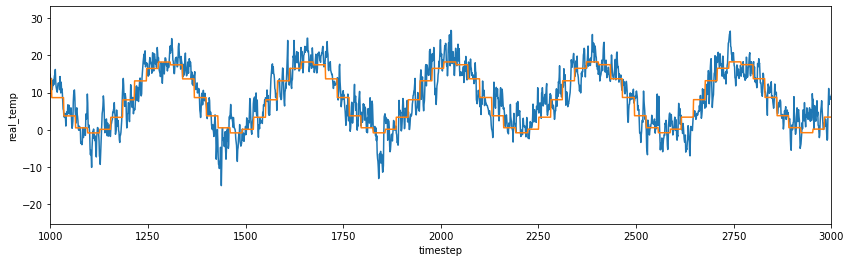

In [117]:
fig, axes = plt.subplots(1)
fig.set_size_inches(14, 4)
sns.lineplot(data=data, x='timestep', y='real_temp')
sns.lineplot(data=data, x='timestep', y='trend_seasonal')
plt.xlim(1000, 3000)

# Step 7 - Extract the remainder

In [119]:
# We want to extract the part of the model that the trend_seasonal is not able to explain
data['remainder'] = data['real_temp'] - data['trend_seasonal']

<AxesSubplot:xlabel='year', ylabel='remainder'>

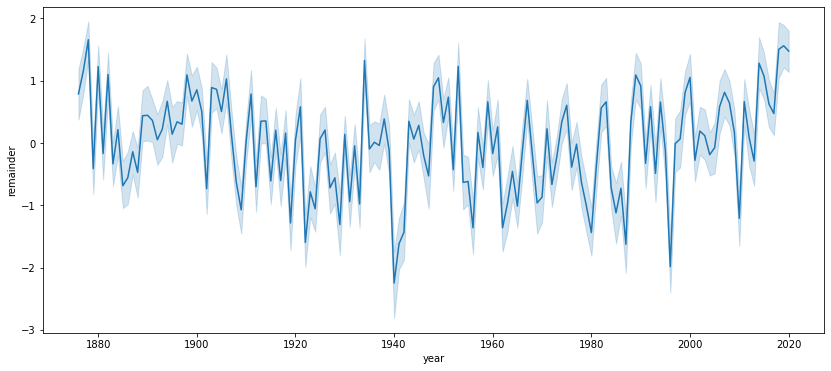

In [120]:
sns.lineplot(x = data['year'], y =data['remainder'])

# Step 8 - Save the remainder

In [121]:
data['remainder'].to_csv('data_remainder_alex.csv')